In [246]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [247]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [248]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [249]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [250]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [251]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [252]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [253]:
len(df)

25867

In [254]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [255]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [256]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [257]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [258]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

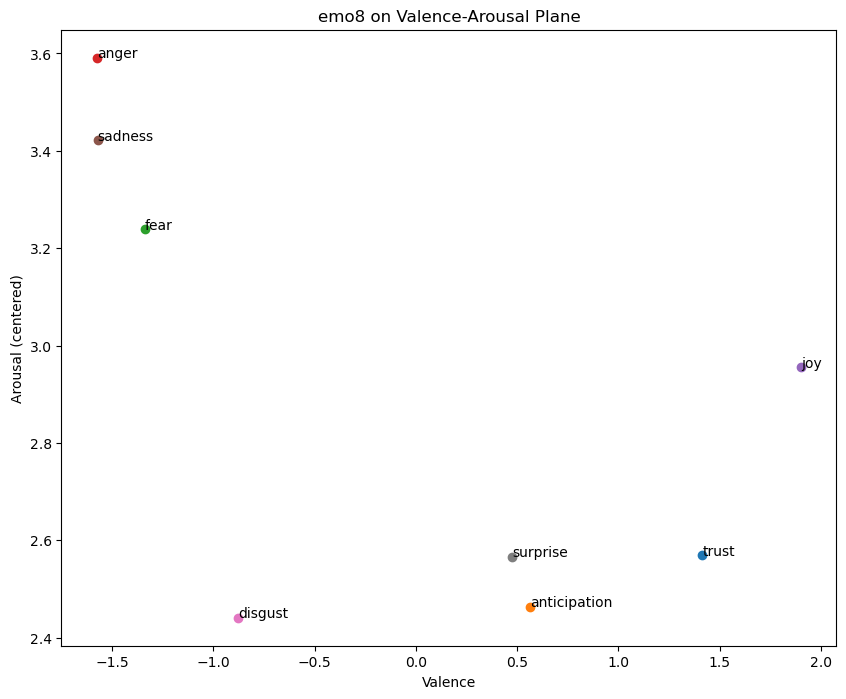

In [259]:
VALENCE_BINS = np.linspace(-3, 3, num=7)
AROUSAL_BINS = np.linspace(0, 6, num=7)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))
emotion_va_bins = {}

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    valence_bin = to_bin(avg_valence, VALENCE_BINS)
    arousal_bin = to_bin(avg_arousal, AROUSAL_BINS)
    emotion_va_bins[emo] = (valence_bin, arousal_bin)
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [260]:
df['valence_bin'] = df['valence'].apply(lambda x: to_bin(x, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda x: to_bin(x, AROUSAL_BINS))

In [261]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,3,2
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,3,2
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,2
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,4,2
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,3


In [262]:
emotion_va_bins

{'trust': (4, 3),
 'anticipation': (4, 2),
 'fear': (2, 3),
 'anger': (1, 4),
 'joy': (5, 3),
 'sadness': (1, 3),
 'disgust': (2, 2),
 'surprise': (3, 3)}

In [263]:
# # Change the bins a bit to be able to seperate them
# # Anger should be in a higher arousal bin
# emotion_va_bins['anger'] = (1, 5)

# # Surprise is typically more aroused so anticipation needs a higher arousal bin
# emotion_va_bins['surprise'] = (3, 4)

# # Fear should have a higher arousal
# emotion_va_bins['fear'] = (2, 3)

# # Trust should have a bit of a lower arousal
# emotion_va_bins['trust'] = (4, 2)

# # Disgust can be a more negative as well
# emotion_va_bins['disgust'] = (3, 4)

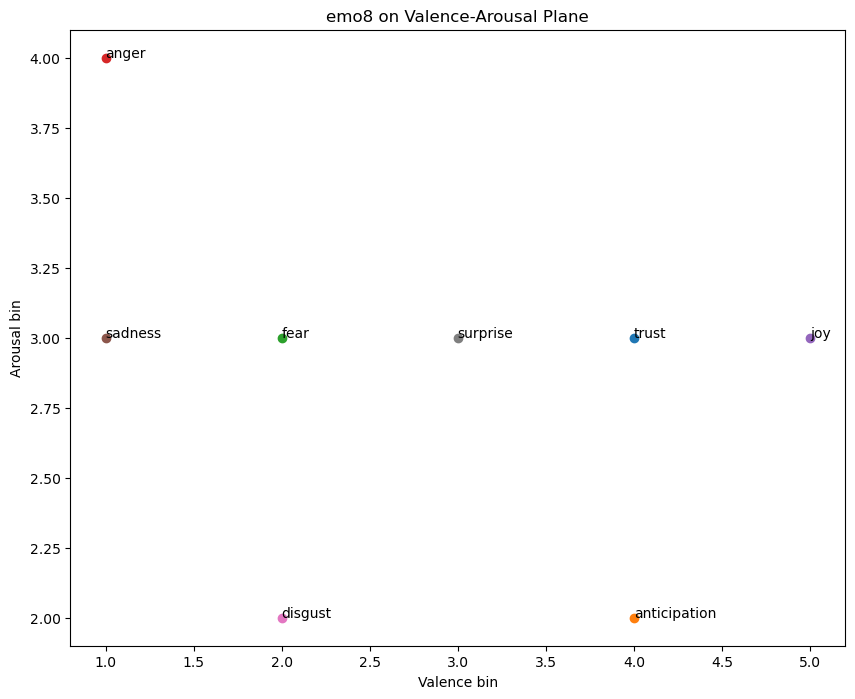

In [264]:
# Now plot the bins
plt.figure(figsize=(10, 8))

for emo in df['emotion'].unique():
    valence_bin, arousal_bin = emotion_va_bins[emo]
    plt.scatter(valence_bin, arousal_bin, label=emo)
    plt.text(valence_bin, arousal_bin, emo)

plt.xlabel('Valence bin')
plt.ylabel('Arousal bin')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [265]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [266]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [267]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [268]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [269]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [270]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [271]:
face_model_base

Sequential(
  (0): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GEL

In [272]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [273]:
scene_model_base

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [274]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [275]:
scene_model_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [276]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

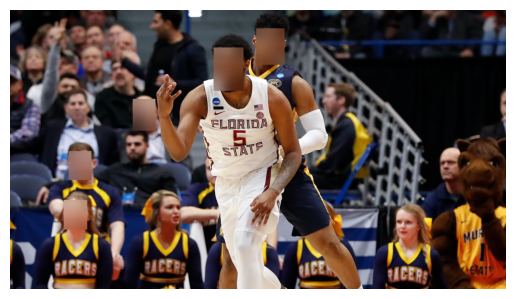

In [277]:
# Show the image but with faces blurred out
def blur_faces(image_path, boxes):
    image = cv2.imread(image_path)
    for box in boxes:
        x1, y1, x2, y2 = box
        face = image[y1:y2, x1:x2]
        blurred_face = cv2.GaussianBlur(face, (99, 99), 30)
        image[y1:y2, x1:x2] = blurred_face
    return image

img_path = os.path.join(findingemo_dir, df.iloc[9]['image_path'])
boxes = df_boxes[df_boxes['index'] == 9][['x1', 'y1', 'x2', 'y2']].values.tolist()
blurred_image = blur_faces(img_path, boxes)

plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [278]:
get_category_name = lambda idx: scene_categories[idx]

In [279]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [280]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [281]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "scenes_5"), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        tensor = super().__getitem__(f"scene_{i}")
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

In [282]:
y1 = face_model_base(faces_dataset[(0, 0)].to(DEVICE).unsqueeze(0))
y1 = y1.last_hidden_state[:, 0, :]

In [283]:
y2 = scene_model_base(scenes_dataset[0].to(DEVICE).unsqueeze(0))

In [284]:
y2 = y2.view(y2.size(0), -1)

In [285]:
y2.shape

torch.Size([1, 512])

In [286]:
scene_model_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# DPL with symbolic knowledge about the data

In [ ]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        output = self.module(*args, **kwargs)

        # Flatten output if it has extra dimensions
        if isinstance(output, torch.Tensor) and output.dim() == 3:
            output = output.squeeze(1)  # Remove the middle dimension [B, 1, C] -> [B, C]
        
        return output
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [288]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [289]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert to numpy arrays with label indices
    label_to_idx = {str(i): i for i in range(len(fe_labels))}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

# Initialize the models, network and final DPL model

In [290]:
from deepproblog.utils.standard_networks import MLP
face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)

In [291]:
class FaceValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)
        

In [292]:
face_val_train_dataset = FaceValDataset(train_indices)
face_val_test_dataset = FaceValDataset(test_indices)

face_val_train_loader = DataLoader(face_val_train_dataset, batch_size=batch_size, shuffle=True)
face_val_test_loader = DataLoader(face_val_test_dataset, batch_size=batch_size, shuffle=False)

In [293]:
def custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight=0.3):
    """
    Loss function that rewards predictions within ±1 bin
    
    Args:
        logits: model predictions (B, num_bins)
        y: true labels (B,)
        weight_tensor: class weights for CE loss
        ce_weight: weight for exact match CE loss
        reg_weight: weight for regression loss
        adjacent_weight: weight for adjacent bin reward (default 0.3)
    """
    probs = logits.softmax(dim=1)  # (B, num_bins)
    num_bins = logits.size(1)
    
    # 1. Regression loss (smooth L1)
    bins = torch.arange(num_bins, device=DEVICE).float()
    v_hat = (probs * bins).sum(dim=1)
    reg_loss = F.smooth_l1_loss(v_hat, y.float())
    
    # 2. Exact match CE loss
    ce_loss = F.cross_entropy(logits, y, weight=weight_tensor)
    
    # 3. Adjacent bin reward: create soft targets
    # For each true label, also give credit to ±1 bins
    soft_targets = torch.zeros_like(probs)
    batch_size = y.size(0)
    
    for i in range(batch_size):
        true_bin = y[i].item()
        # Main target gets full weight
        soft_targets[i, true_bin] = 1.0
        
        # Adjacent bins get partial weight
        if true_bin > 0:
            soft_targets[i, true_bin - 1] = adjacent_weight
        if true_bin < num_bins - 1:
            soft_targets[i, true_bin + 1] = adjacent_weight
    
    # Normalize soft targets to sum to 1
    soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)
    
    # KL divergence between predictions and soft targets
    log_probs = F.log_softmax(logits, dim=1)
    adjacent_loss = F.kl_div(log_probs, soft_targets, reduction='batchmean')
    
    # Combine losses
    total_loss = ce_weight * ce_loss + reg_weight * reg_loss + adjacent_weight * adjacent_loss
    
    return total_loss

In [294]:
def train_epoch(model, loader, optimizer, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    model.train()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Track ±1 accuracy during training
    total_samples = 0

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).long()  # CE requires long dtype

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)                    # (B, num_bins)
        loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_correct_adjacent += ((preds - y).abs() <= 1).sum().item()  # Count ±1 predictions
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples  # Calculate ±1 accuracy

    return avg_loss, accuracy, accuracy_adjacent

In [295]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, labels, allow_adjacent=True, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0

    all_labels = []
    all_preds = []

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Exact matches
            total_correct += (preds == y).sum().item()
            
            # Adjacent matches (within 1 bin)
            if allow_adjacent:
                adjacent_correct = ((preds - y).abs() <= 1).sum().item()
                total_correct_adjacent += adjacent_correct
            
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(labels)), zero_division=0
    )
    
    # Overall metrics
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples if allow_adjacent else None
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'accuracy_adjacent': accuracy_adjacent,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:                {results['loss']:.4f}")
    print(f"Accuracy (Exact):    {results['accuracy']:.4f}")
    if results.get('accuracy_adjacent') is not None:
        print(f"Accuracy (±1 bin):   {results['accuracy_adjacent']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Label':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [296]:
valence_bin_labels = [f"V{i}" for i in range(len(VALENCE_BINS))]
arousal_bin_labels = [f"A{i}" for i in range(len(AROUSAL_BINS))]

In [297]:
class_counts = np.bincount(df['valence_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.1760, Train Accuracy: 0.2380, Train Adjacent Accuracy: 0.6035

Epoch 2/20


Train Loss: 1.1254, Train Accuracy: 0.2620, Train Adjacent Accuracy: 0.6459

Epoch 3/20


Train Loss: 1.1064, Train Accuracy: 0.2729, Train Adjacent Accuracy: 0.6532

Epoch 4/20


Train Loss: 1.0950, Train Accuracy: 0.2799, Train Adjacent Accuracy: 0.6563

Epoch 5/20


Train Loss: 1.0850, Train Accuracy: 0.2829, Train Adjacent Accuracy: 0.6579



Overall Metrics:
Loss:                1.0959
Accuracy (Exact):    0.2779
Accuracy (±1 bin):   0.6517

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2114       0.3430       0.2616       379       
V1              0.2209       0.2281       0.2245       583       
V2              0.2485       0.1805       0.2091       698       
V3              0.2225       0.1272       0.1619       668       
V4              0.3014       0.3762       0.3347       1228      
V5              0.3147       0.2161       0.2563       1018      
V6              0.3373       0.4700       0.3928       600       
----------------------------------------------------------------------
Macro Avg       0.2653       0.2773       0.2630       5174      
Weighted Avg    0.2752       0.2779       0.2690       5174      


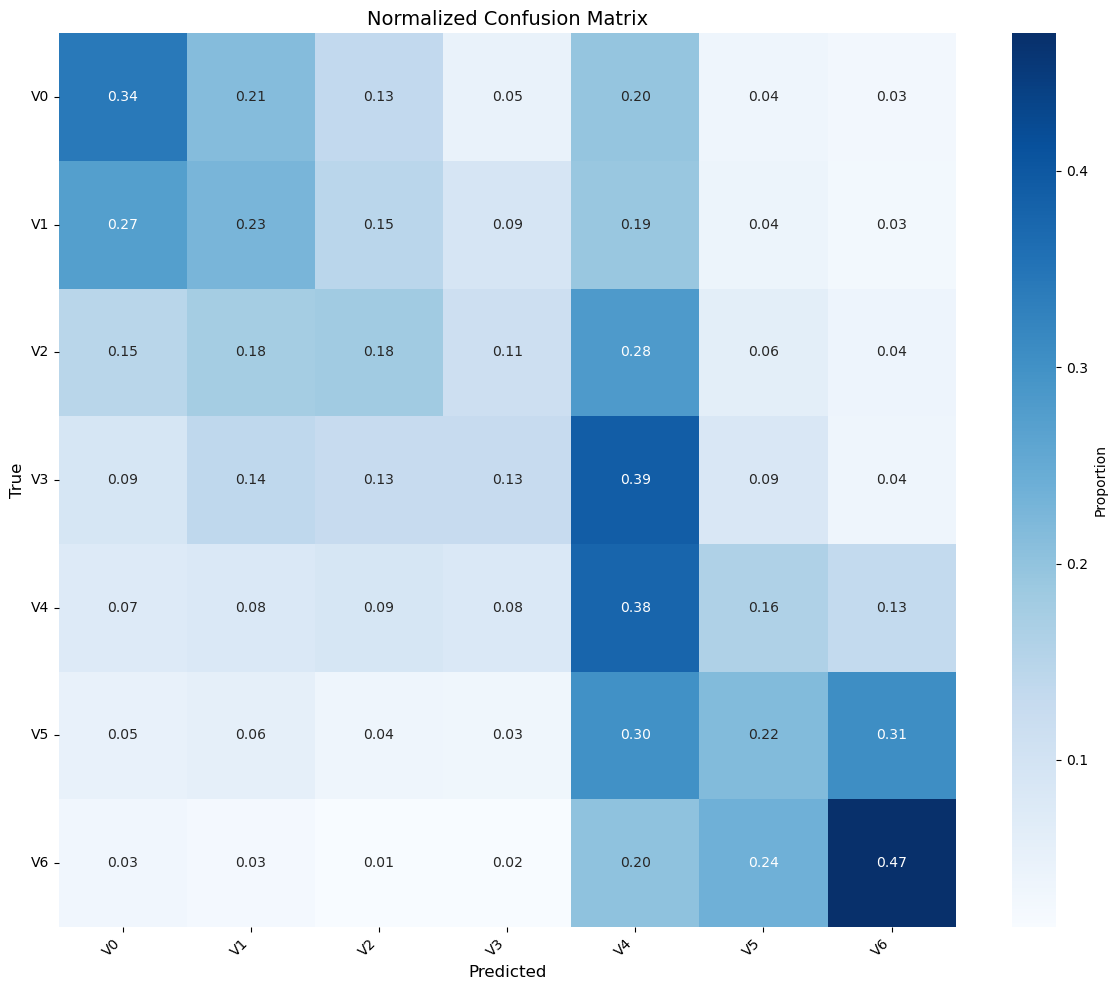


Epoch 6/20


Train Loss: 1.0773, Train Accuracy: 0.2894, Train Adjacent Accuracy: 0.6584

Epoch 7/20


Train Loss: 1.0710, Train Accuracy: 0.2943, Train Adjacent Accuracy: 0.6657

Epoch 8/20


Train Loss: 1.0646, Train Accuracy: 0.2953, Train Adjacent Accuracy: 0.6659

Epoch 9/20


Train Loss: 1.0603, Train Accuracy: 0.2964, Train Adjacent Accuracy: 0.6675

Epoch 10/20


Train Loss: 1.0548, Train Accuracy: 0.3012, Train Adjacent Accuracy: 0.6712



Overall Metrics:
Loss:                1.0904
Accuracy (Exact):    0.2768
Accuracy (±1 bin):   0.6598

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2378       0.3219       0.2735       379       
V1              0.2147       0.3156       0.2556       583       
V2              0.2517       0.1089       0.1520       698       
V3              0.2337       0.2410       0.2373       668       
V4              0.3140       0.2606       0.2848       1228      
V5              0.3031       0.2790       0.2905       1018      
V6              0.3326       0.4750       0.3912       600       
----------------------------------------------------------------------
Macro Avg       0.2696       0.2860       0.2693       5174      
Weighted Avg    0.2785       0.2768       0.2701       5174      


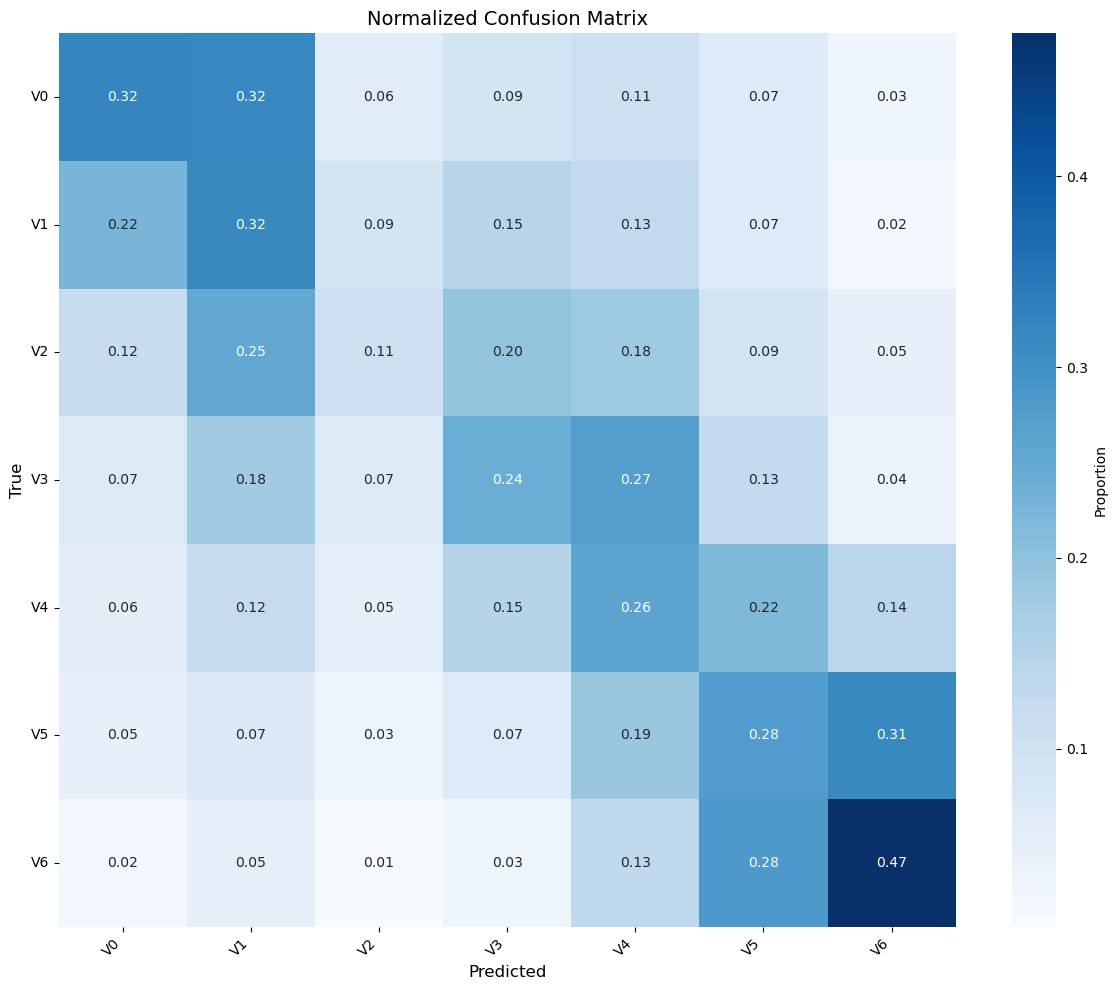


Epoch 11/20


Train Loss: 1.0486, Train Accuracy: 0.3025, Train Adjacent Accuracy: 0.6794

Epoch 12/20


Train Loss: 1.0440, Train Accuracy: 0.3090, Train Adjacent Accuracy: 0.6783

Epoch 13/20


Train Loss: 1.0375, Train Accuracy: 0.3100, Train Adjacent Accuracy: 0.6836

Epoch 14/20


Train Loss: 1.0321, Train Accuracy: 0.3148, Train Adjacent Accuracy: 0.6853

Epoch 15/20


Train Loss: 1.0261, Train Accuracy: 0.3185, Train Adjacent Accuracy: 0.6875



Overall Metrics:
Loss:                1.0905
Accuracy (Exact):    0.2841
Accuracy (±1 bin):   0.6494

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2338       0.3430       0.2781       379       
V1              0.2413       0.2744       0.2568       583       
V2              0.2347       0.1977       0.2146       698       
V3              0.2480       0.2290       0.2381       668       
V4              0.3220       0.2850       0.3024       1228      
V5              0.3162       0.2112       0.2532       1018      
V6              0.3296       0.5400       0.4093       600       
----------------------------------------------------------------------
Macro Avg       0.2751       0.2972       0.2789       5174      
Weighted Avg    0.2848       0.2841       0.2781       5174      


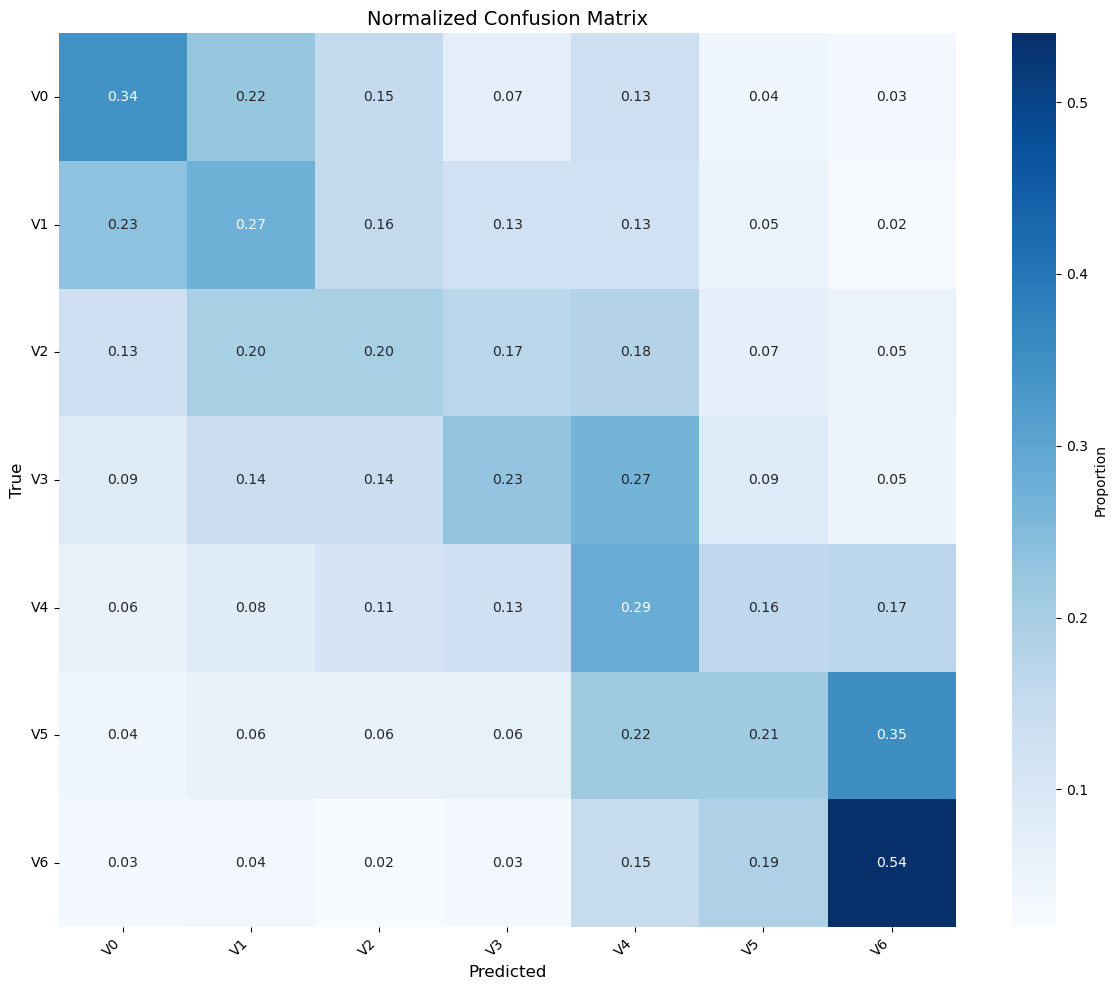


Epoch 16/20


Train Loss: 1.0203, Train Accuracy: 0.3197, Train Adjacent Accuracy: 0.6899

Epoch 17/20


Train Loss: 1.0138, Train Accuracy: 0.3241, Train Adjacent Accuracy: 0.6988

Epoch 18/20


Train Loss: 1.0078, Train Accuracy: 0.3268, Train Adjacent Accuracy: 0.6979

Epoch 19/20


Train Loss: 1.0020, Train Accuracy: 0.3266, Train Adjacent Accuracy: 0.7010

Epoch 20/20


Train Loss: 0.9952, Train Accuracy: 0.3333, Train Adjacent Accuracy: 0.7068



Overall Metrics:
Loss:                1.0997
Accuracy (Exact):    0.2820
Accuracy (±1 bin):   0.6488

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2230       0.4037       0.2873       379       
V1              0.2356       0.2316       0.2336       583       
V2              0.2293       0.1948       0.2107       698       
V3              0.2607       0.2635       0.2621       668       
V4              0.3276       0.2630       0.2918       1228      
V5              0.3225       0.2927       0.3069       1018      
V6              0.3229       0.3967       0.3560       600       
----------------------------------------------------------------------
Macro Avg       0.2745       0.2923       0.2783       5174      
Weighted Avg    0.2861       0.2820       0.2805       5174      


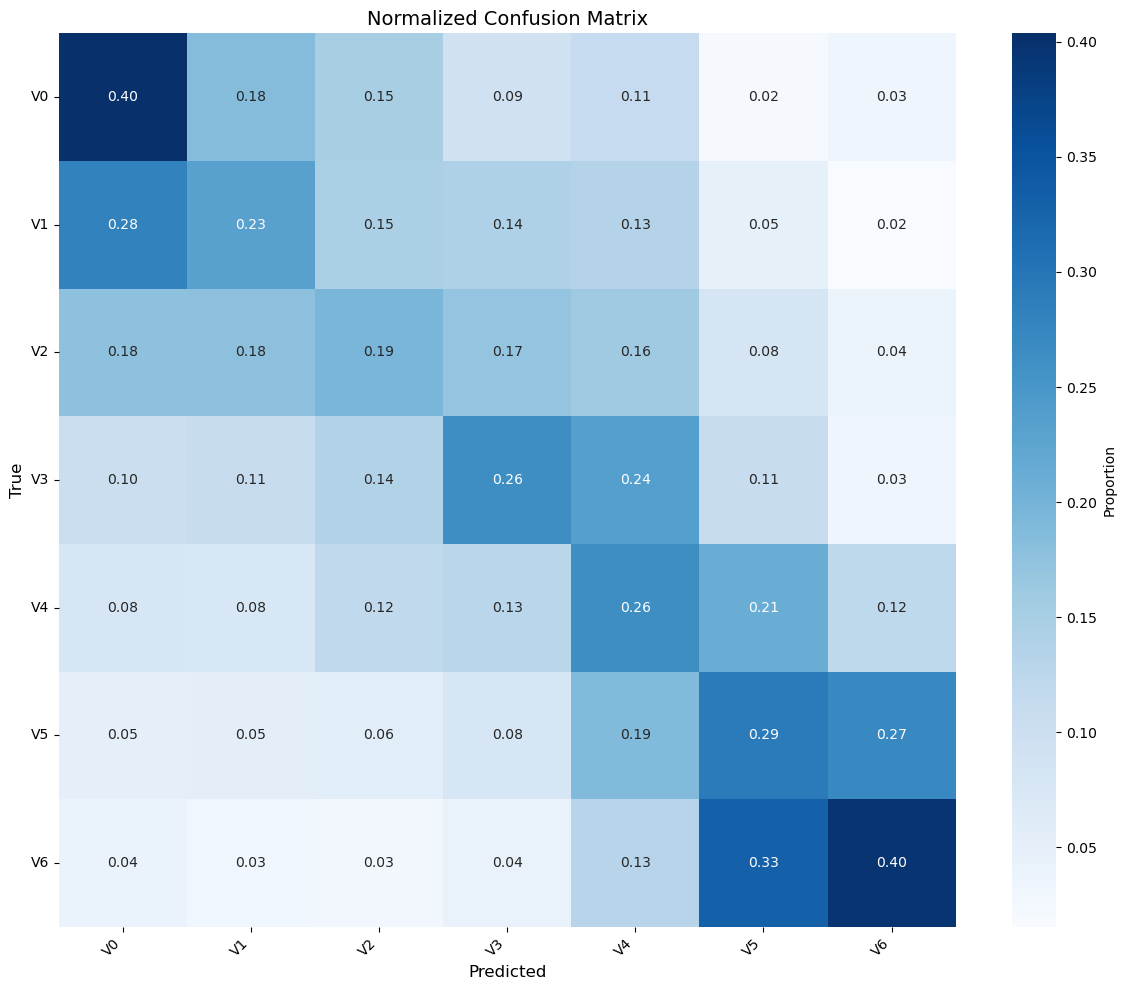

<All keys matched successfully>

In [298]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        face_val_model, 
        face_val_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_val_model, 
            face_val_test_loader, 
            valence_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
            )
        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

torch.save(face_val_model.state_dict(), os.path.join(model_dir, "face_val_model.pth"))
# Load the trained baseline model weights

face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)


face_val_model.load_state_dict(torch.load(os.path.join(model_dir, "face_val_model.pth")))

In [300]:
face_val_network = Network(face_val_model, "face_val_model", batching=True)
face_val_network.optimizer = optimizer

In [301]:
face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)


In [302]:
class FaceAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [303]:
face_aro_train_dataset = FaceAroDataset(train_indices)
face_aro_test_dataset = FaceAroDataset(test_indices)

face_aro_train_loader = DataLoader(face_aro_train_dataset, batch_size=batch_size, shuffle=True)
face_aro_test_loader = DataLoader(face_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [304]:
class_counts = np.bincount(df['arousal_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.2750, Train Accuracy: 0.1887, Train Adjacent Accuracy: 0.5334

Epoch 2/20


Train Loss: 1.2551, Train Accuracy: 0.2083, Train Adjacent Accuracy: 0.5498

Epoch 3/20


Train Loss: 1.2445, Train Accuracy: 0.2160, Train Adjacent Accuracy: 0.5567

Epoch 4/20


Train Loss: 1.2371, Train Accuracy: 0.2202, Train Adjacent Accuracy: 0.5572

Epoch 5/20


Train Loss: 1.2312, Train Accuracy: 0.2274, Train Adjacent Accuracy: 0.5679



Overall Metrics:
Loss:                1.2378
Accuracy (Exact):    0.1948
Accuracy (±1 bin):   0.5445

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0000       0.0000       0.0000       288       
A1              0.2459       0.2808       0.2622       901       
A2              0.2420       0.2005       0.2193       1092      
A3              0.1860       0.2213       0.2021       1035      
A4              0.1704       0.1322       0.1489       915       
A5              0.1625       0.1098       0.1310       592       
A6              0.1346       0.3447       0.1936       351       
----------------------------------------------------------------------
Macro Avg       0.1631       0.1842       0.1653       5174      
Weighted Avg    0.1890       0.1948       0.1868       5174      


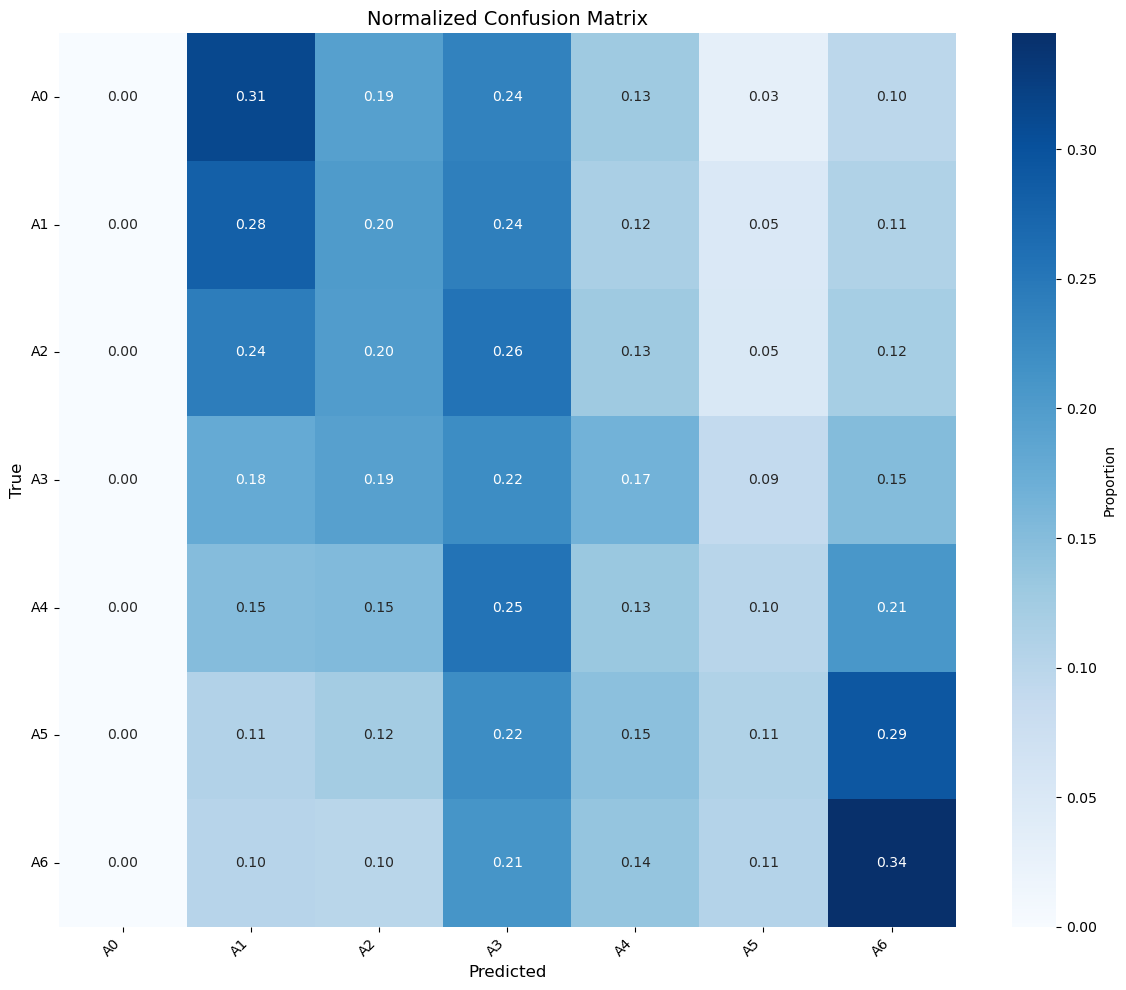


Epoch 6/20


Train Loss: 1.2274, Train Accuracy: 0.2294, Train Adjacent Accuracy: 0.5664

Epoch 7/20


Train Loss: 1.2221, Train Accuracy: 0.2370, Train Adjacent Accuracy: 0.5730

Epoch 8/20


Train Loss: 1.2161, Train Accuracy: 0.2341, Train Adjacent Accuracy: 0.5786

Epoch 9/20


Train Loss: 1.2122, Train Accuracy: 0.2416, Train Adjacent Accuracy: 0.5804

Epoch 10/20


Train Loss: 1.2058, Train Accuracy: 0.2474, Train Adjacent Accuracy: 0.5846



Overall Metrics:
Loss:                1.2405
Accuracy (Exact):    0.2074
Accuracy (±1 bin):   0.5547

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0000       0.0000       0.0000       288       
A1              0.2142       0.4240       0.2846       901       
A2              0.2305       0.3114       0.2649       1092      
A3              0.1836       0.1208       0.1457       1035      
A4              0.2213       0.1115       0.1483       915       
A5              0.1873       0.1098       0.1384       592       
A6              0.1385       0.1681       0.1519       351       
----------------------------------------------------------------------
Macro Avg       0.1679       0.1779       0.1620       5174      
Weighted Avg    0.1926       0.2074       0.1870       5174      


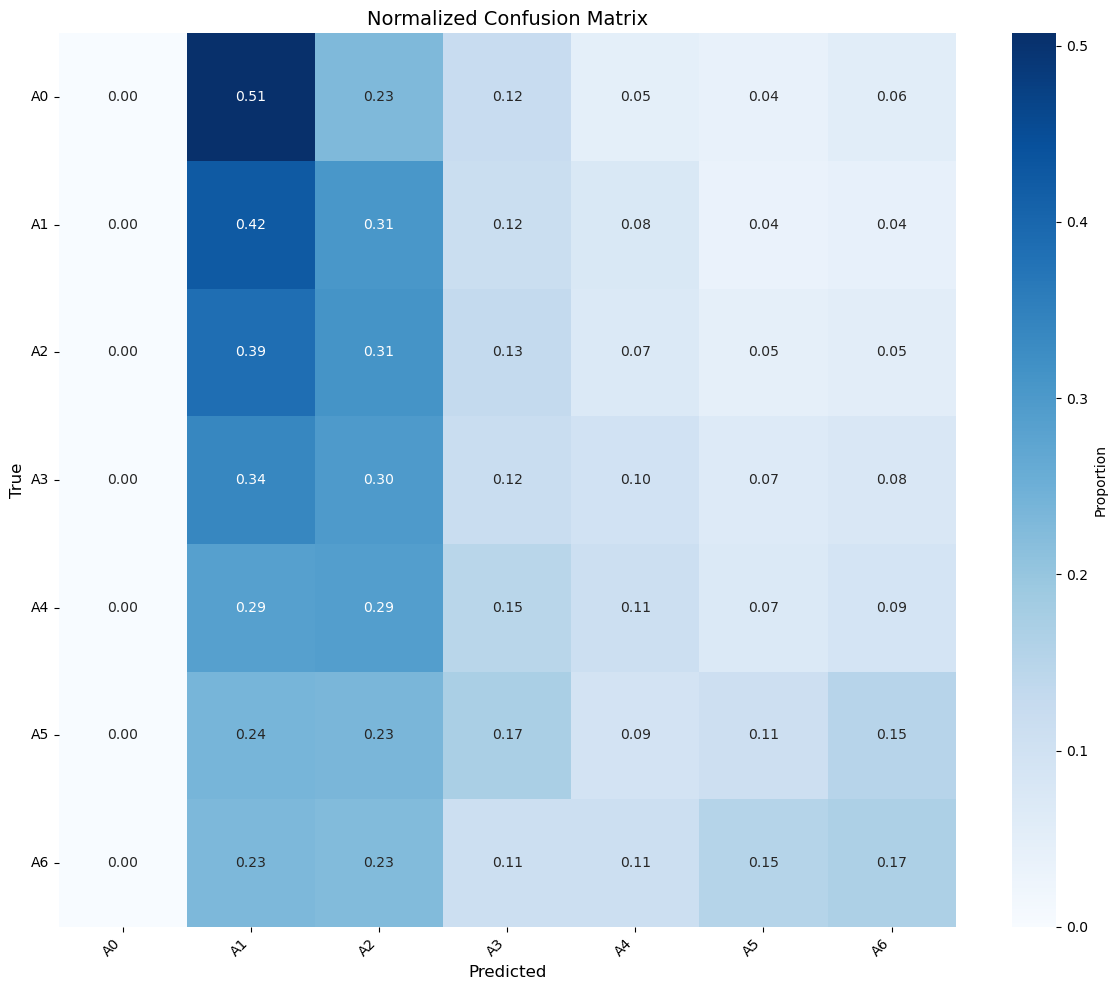


Epoch 11/20


Train Loss: 1.2001, Train Accuracy: 0.2478, Train Adjacent Accuracy: 0.5908

Epoch 12/20


Train Loss: 1.1951, Train Accuracy: 0.2479, Train Adjacent Accuracy: 0.5903

Epoch 13/20


Train Loss: 1.1883, Train Accuracy: 0.2524, Train Adjacent Accuracy: 0.5919

Epoch 14/20


Train Loss: 1.1812, Train Accuracy: 0.2559, Train Adjacent Accuracy: 0.6012

Epoch 15/20


Train Loss: 1.1745, Train Accuracy: 0.2641, Train Adjacent Accuracy: 0.6038



Overall Metrics:
Loss:                1.2476
Accuracy (Exact):    0.2026
Accuracy (±1 bin):   0.5584

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0317       0.0139       0.0193       288       
A1              0.2192       0.2508       0.2340       901       
A2              0.2227       0.3452       0.2707       1092      
A3              0.1990       0.1845       0.1915       1035      
A4              0.2033       0.1617       0.1802       915       
A5              0.1633       0.0693       0.0973       592       
A6              0.1584       0.1738       0.1658       351       
----------------------------------------------------------------------
Macro Avg       0.1711       0.1713       0.1655       5174      
Weighted Avg    0.1921       0.2026       0.1915       5174      


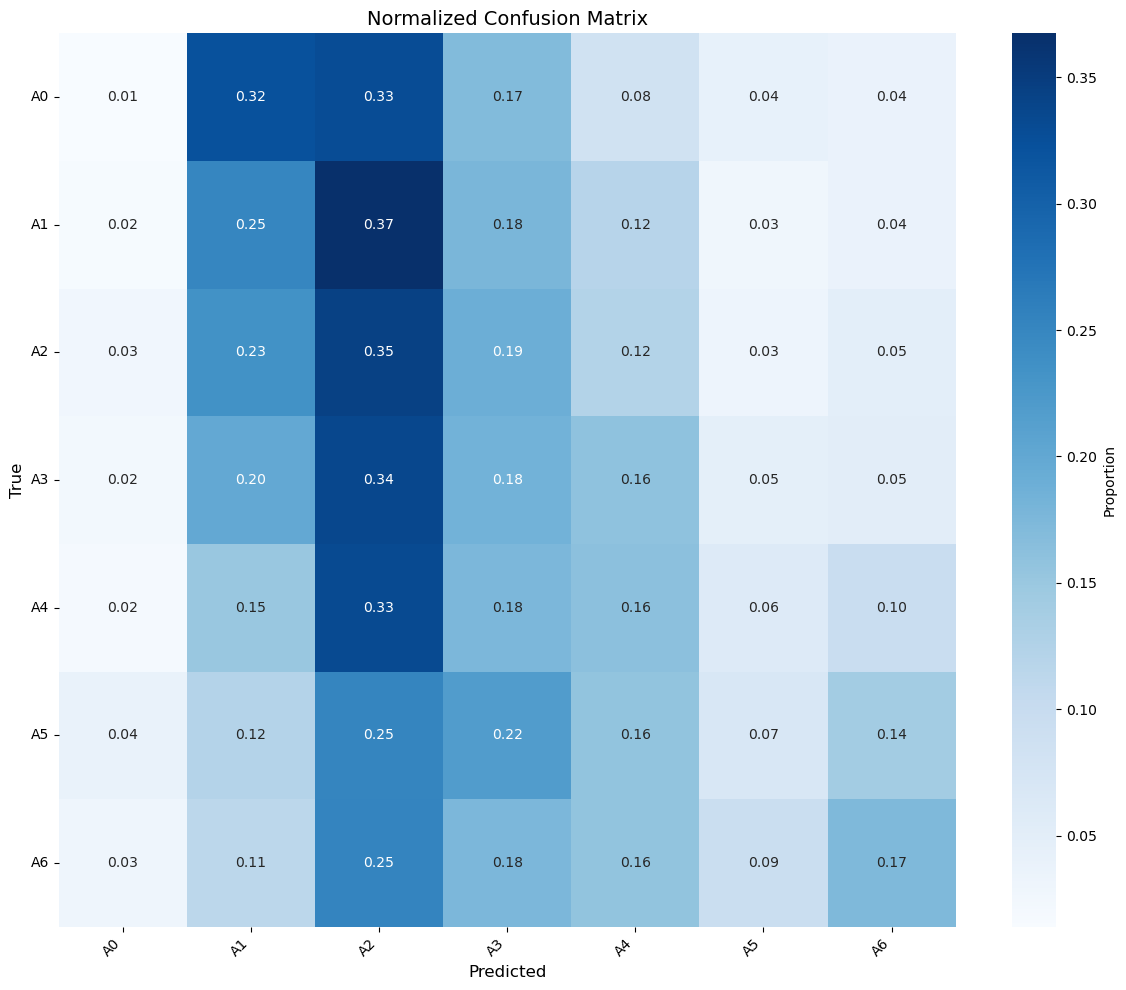


Epoch 16/20


Train Loss: 1.1663, Train Accuracy: 0.2651, Train Adjacent Accuracy: 0.6051

Epoch 17/20


Train Loss: 1.1579, Train Accuracy: 0.2680, Train Adjacent Accuracy: 0.6060

Epoch 18/20


Train Loss: 1.1496, Train Accuracy: 0.2723, Train Adjacent Accuracy: 0.6150

Epoch 19/20


Train Loss: 1.1402, Train Accuracy: 0.2775, Train Adjacent Accuracy: 0.6163

Epoch 20/20


Train Loss: 1.1326, Train Accuracy: 0.2808, Train Adjacent Accuracy: 0.6222



Overall Metrics:
Loss:                1.2601
Accuracy (Exact):    0.1838
Accuracy (±1 bin):   0.5253

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0623       0.0660       0.0641       288       
A1              0.2124       0.2431       0.2267       901       
A2              0.2218       0.2866       0.2501       1092      
A3              0.1750       0.1082       0.1337       1035      
A4              0.1911       0.1355       0.1586       915       
A5              0.1582       0.1419       0.1496       592       
A6              0.1318       0.2279       0.1670       351       
----------------------------------------------------------------------
Macro Avg       0.1647       0.1727       0.1643       5174      
Weighted Avg    0.1831       0.1838       0.1791       5174      


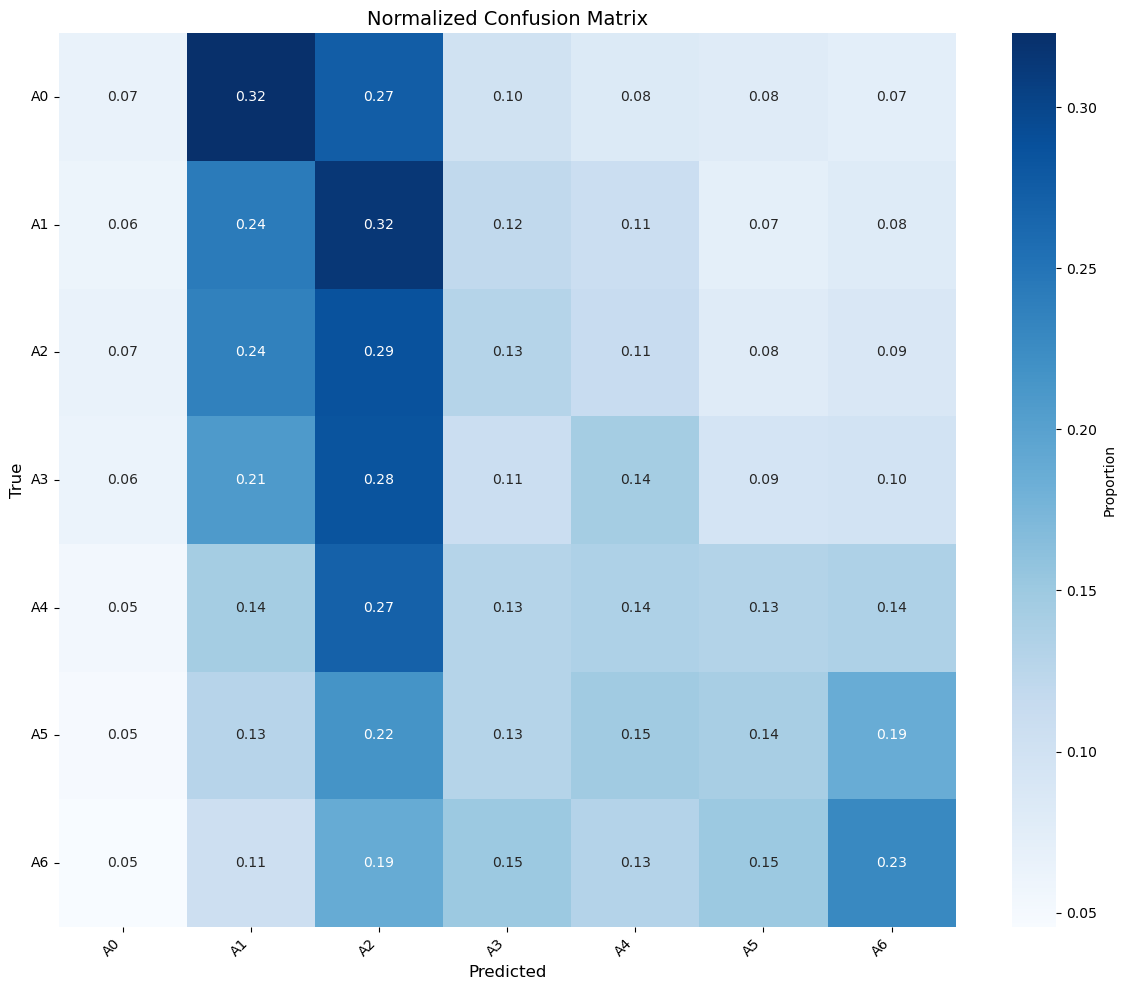

<All keys matched successfully>

In [305]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        face_aro_model, 
        face_aro_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_aro_model, 
            face_aro_test_loader, 
            arousal_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
        )
        print_detailed_metrics(results, arousal_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

torch.save(face_aro_model.state_dict(), os.path.join(model_dir, "face_aro_model.pth"))
# Load the trained baseline model weights

face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)

face_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "face_aro_model.pth")))

In [ ]:
face_aro_network = Network(face_aro_model, "face_aro_model", batching=True)
face_aro_network.optimizer = optimizer

In [307]:
scene_model_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [308]:
scene_val_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)

In [309]:
class SceneValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
        scene_feature = torch.load(feature_path)
        scene_feature = scene_feature.squeeze()

        return scene_feature.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)

In [310]:
scene_val_train_dataset = SceneValDataset(train_indices)
scene_val_test_dataset = SceneValDataset(test_indices)

scene_val_train_loader = DataLoader(scene_val_train_dataset, batch_size=batch_size, shuffle=True)
scene_val_test_loader = DataLoader(scene_val_test_dataset, batch_size=batch_size, shuffle=False)

In [311]:
class_counts = np.bincount(df['valence_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.2905, Train Accuracy: 0.2055, Train Adjacent Accuracy: 0.5195

Epoch 2/20


Train Loss: 1.2432, Train Accuracy: 0.2236, Train Adjacent Accuracy: 0.5468

Epoch 3/20


Train Loss: 1.2287, Train Accuracy: 0.2303, Train Adjacent Accuracy: 0.5556

Epoch 4/20


Train Loss: 1.2183, Train Accuracy: 0.2381, Train Adjacent Accuracy: 0.5598

Epoch 5/20


Train Loss: 1.2074, Train Accuracy: 0.2417, Train Adjacent Accuracy: 0.5675



Overall Metrics:
Loss:                1.2130
Accuracy (Exact):    0.2308
Accuracy (±1 bin):   0.5831

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2622       0.1979       0.2256       379       
V1              0.1940       0.3465       0.2488       583       
V2              0.1894       0.1175       0.1450       698       
V3              0.1854       0.1557       0.1692       668       
V4              0.3087       0.2386       0.2692       1228      
V5              0.2497       0.1965       0.2199       1018      
V6              0.2158       0.3967       0.2795       600       
----------------------------------------------------------------------
Macro Avg       0.2293       0.2356       0.2225       5174      
Weighted Avg    0.2380       0.2308       0.2255       5174      


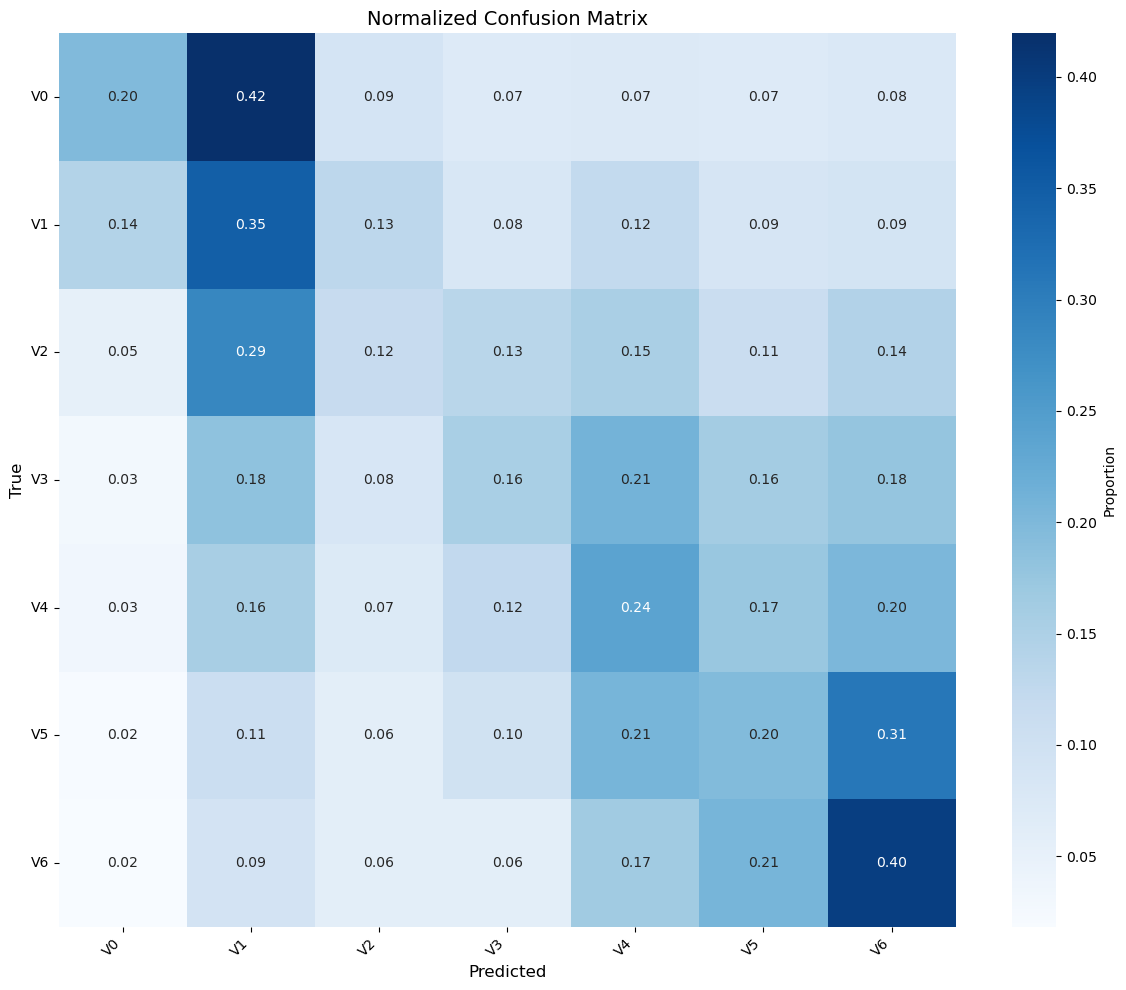


Epoch 6/20


Train Loss: 1.1985, Train Accuracy: 0.2446, Train Adjacent Accuracy: 0.5759

Epoch 7/20


Train Loss: 1.1877, Train Accuracy: 0.2556, Train Adjacent Accuracy: 0.5815

Epoch 8/20


Train Loss: 1.1780, Train Accuracy: 0.2590, Train Adjacent Accuracy: 0.5902

Epoch 9/20


Train Loss: 1.1672, Train Accuracy: 0.2659, Train Adjacent Accuracy: 0.5977

Epoch 10/20


Train Loss: 1.1576, Train Accuracy: 0.2701, Train Adjacent Accuracy: 0.5997



Overall Metrics:
Loss:                1.2063
Accuracy (Exact):    0.2356
Accuracy (±1 bin):   0.5841

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2004       0.5172       0.2889       379       
V1              0.2191       0.1338       0.1661       583       
V2              0.1934       0.0587       0.0901       698       
V3              0.1946       0.1287       0.1550       668       
V4              0.3147       0.1327       0.1867       1228      
V5              0.2439       0.4990       0.3276       1018      
V6              0.2513       0.2450       0.2481       600       
----------------------------------------------------------------------
Macro Avg       0.2310       0.2450       0.2089       5174      
Weighted Avg    0.2424       0.2356       0.2096       5174      


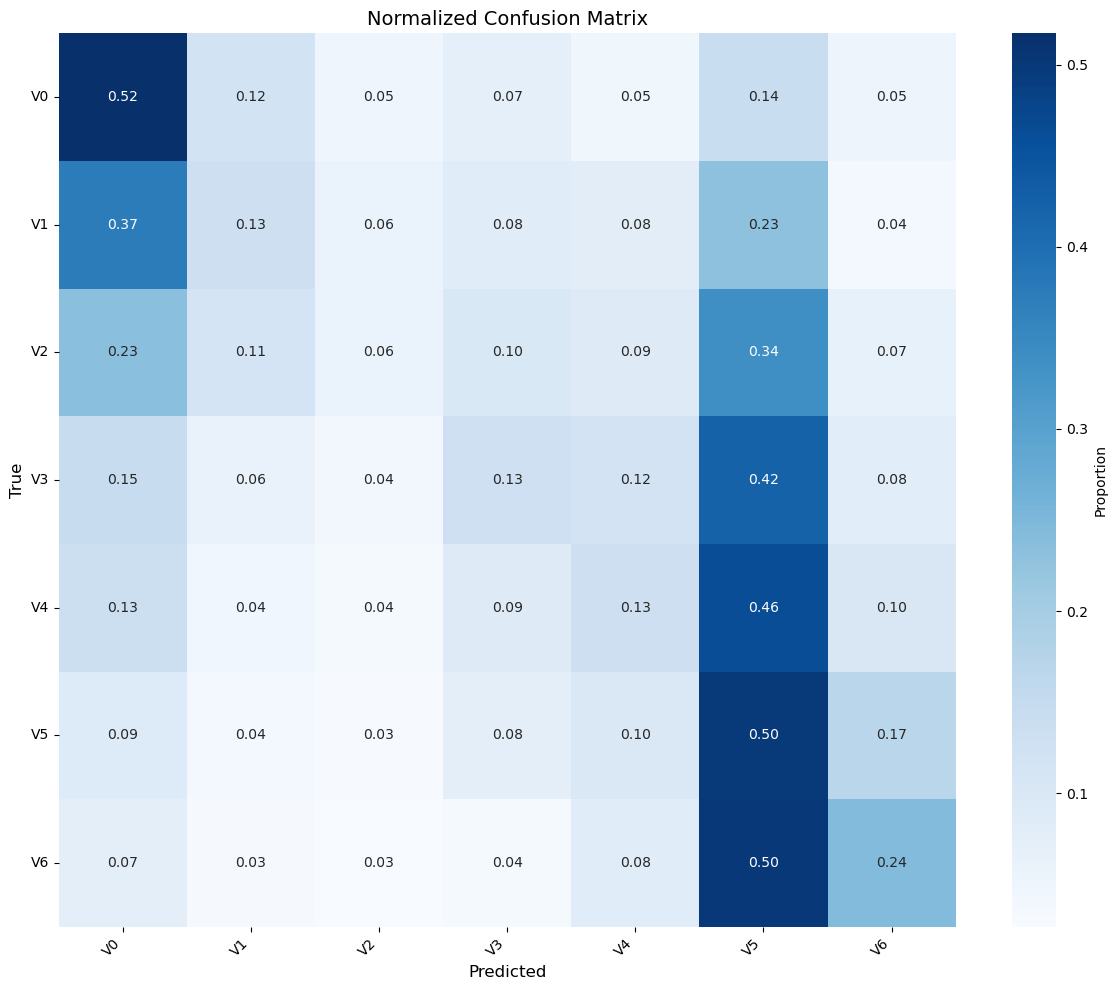


Epoch 11/20


Train Loss: 1.1445, Train Accuracy: 0.2721, Train Adjacent Accuracy: 0.6107

Epoch 12/20


Train Loss: 1.1344, Train Accuracy: 0.2781, Train Adjacent Accuracy: 0.6164

Epoch 13/20


Train Loss: 1.1219, Train Accuracy: 0.2833, Train Adjacent Accuracy: 0.6219

Epoch 14/20


Train Loss: 1.1100, Train Accuracy: 0.2882, Train Adjacent Accuracy: 0.6278

Epoch 15/20


Train Loss: 1.0971, Train Accuracy: 0.2950, Train Adjacent Accuracy: 0.6370



Overall Metrics:
Loss:                1.2157
Accuracy (Exact):    0.2227
Accuracy (±1 bin):   0.5574

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.1956       0.5567       0.2894       379       
V1              0.1818       0.0995       0.1286       583       
V2              0.2031       0.0931       0.1277       698       
V3              0.1784       0.1707       0.1744       668       
V4              0.3086       0.2166       0.2545       1228      
V5              0.2349       0.1916       0.2110       1018      
V6              0.2160       0.4050       0.2817       600       
----------------------------------------------------------------------
Macro Avg       0.2169       0.2476       0.2096       5174      
Weighted Avg    0.2298       0.2227       0.2101       5174      


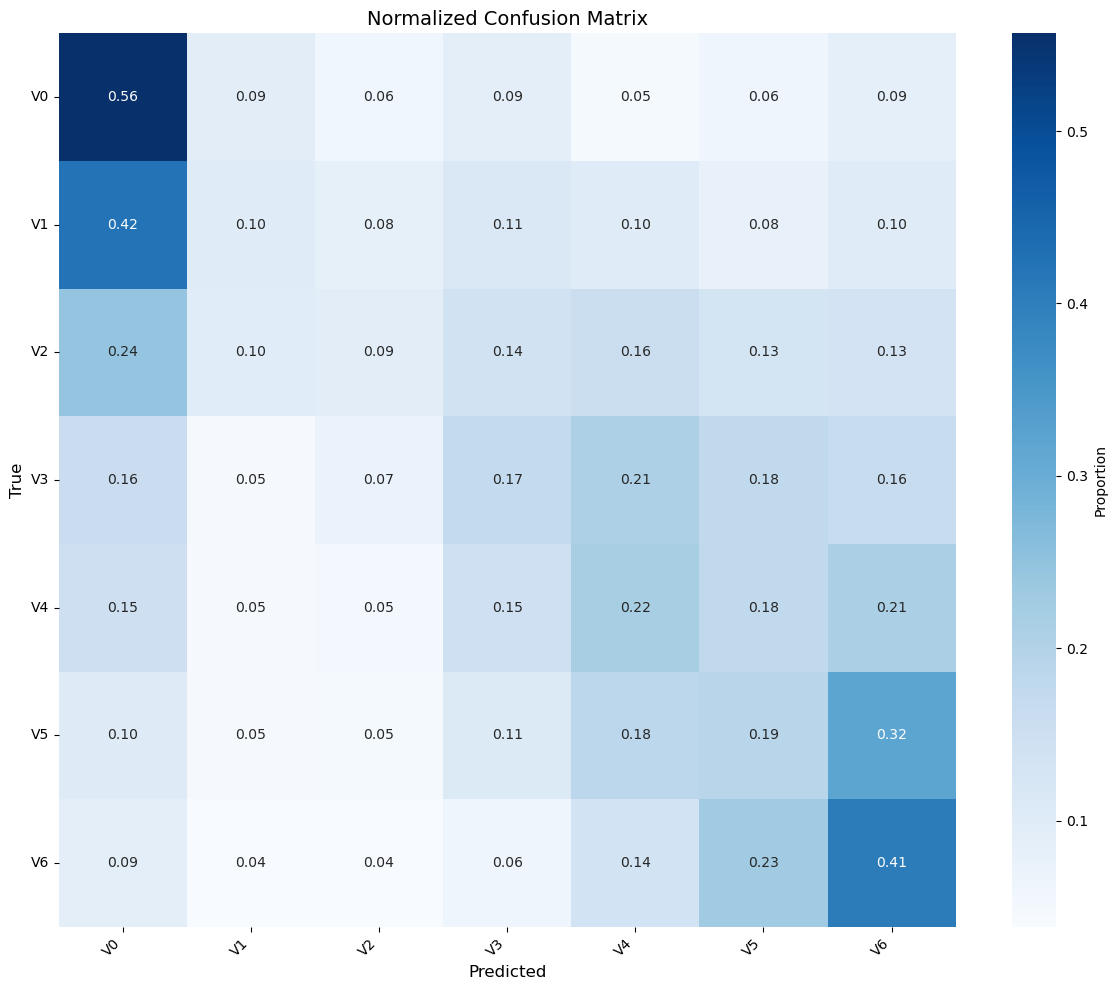


Epoch 16/20


Train Loss: 1.0858, Train Accuracy: 0.2992, Train Adjacent Accuracy: 0.6408

Epoch 17/20


Train Loss: 1.0707, Train Accuracy: 0.3013, Train Adjacent Accuracy: 0.6506

Epoch 18/20


Train Loss: 1.0571, Train Accuracy: 0.3100, Train Adjacent Accuracy: 0.6604

Epoch 19/20


Train Loss: 1.0458, Train Accuracy: 0.3146, Train Adjacent Accuracy: 0.6623

Epoch 20/20


Train Loss: 1.0325, Train Accuracy: 0.3216, Train Adjacent Accuracy: 0.6704



Overall Metrics:
Loss:                1.2314
Accuracy (Exact):    0.2209
Accuracy (±1 bin):   0.5628

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2226       0.3113       0.2596       379       
V1              0.2060       0.2470       0.2246       583       
V2              0.1993       0.1590       0.1769       698       
V3              0.1970       0.1976       0.1973       668       
V4              0.2796       0.1906       0.2266       1228      
V5              0.2262       0.1473       0.1785       1018      
V6              0.2085       0.4233       0.2794       600       
----------------------------------------------------------------------
Macro Avg       0.2199       0.2395       0.2204       5174      
Weighted Avg    0.2269       0.2209       0.2150       5174      


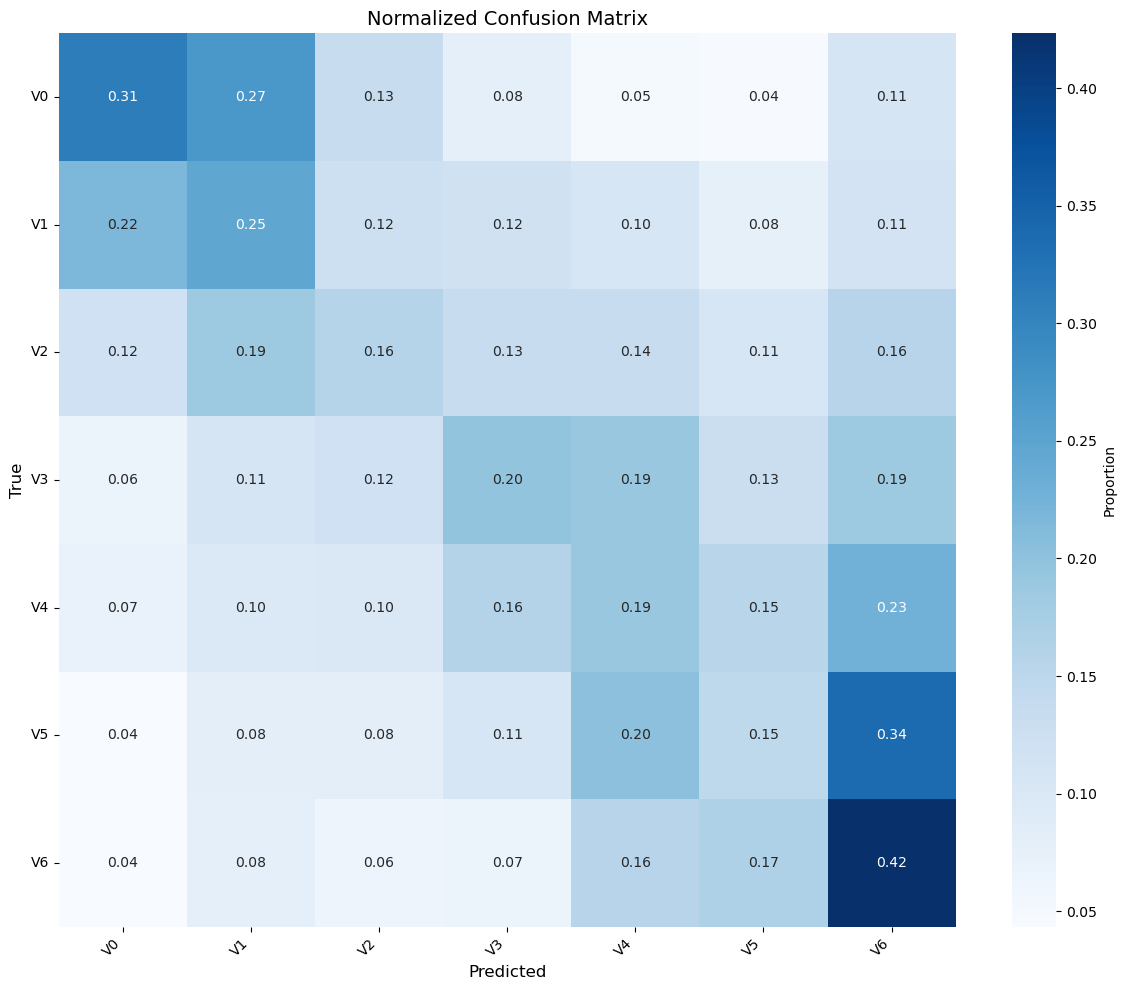

<All keys matched successfully>

In [312]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    scene_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        scene_val_model, 
        scene_val_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            scene_val_model, 
            scene_val_test_loader, 
            valence_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
            )
        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

torch.save(scene_val_model.state_dict(), os.path.join(model_dir, "scene_val_model.pth"))
# Load the trained baseline model weights

scene_val_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)
    activation=nn.ReLU,
    softmax=True,
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)
scene_val_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_val_model.pth")))

In [313]:
scene_val_network = Network(scene_val_model, "scene_val_model", batching=True)
scene_val_network.optimizer = optimizer

In [314]:
scene_aro_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

In [315]:
class SceneAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
        scene_feature = torch.load(feature_path)
        scene_feature = scene_feature.squeeze()

        return scene_feature.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [316]:
scene_aro_train_dataset = SceneAroDataset(train_indices)
scene_aro_test_dataset = SceneAroDataset(test_indices)

scene_aro_train_loader = DataLoader(scene_aro_train_dataset, batch_size=batch_size, shuffle=True)
scene_aro_test_loader = DataLoader(scene_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [317]:
class_counts = np.bincount(df['arousal_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.2688, Train Accuracy: 0.2040, Train Adjacent Accuracy: 0.5610

Epoch 2/20


Train Loss: 1.2530, Train Accuracy: 0.2148, Train Adjacent Accuracy: 0.5526

Epoch 3/20


Train Loss: 1.2468, Train Accuracy: 0.2190, Train Adjacent Accuracy: 0.5512

Epoch 4/20


Train Loss: 1.2423, Train Accuracy: 0.2220, Train Adjacent Accuracy: 0.5578

Epoch 5/20


Train Loss: 1.2373, Train Accuracy: 0.2258, Train Adjacent Accuracy: 0.5609



Overall Metrics:
Loss:                1.2454
Accuracy (Exact):    0.2163
Accuracy (±1 bin):   0.5810

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.1395       0.0208       0.0363       288       
A1              0.2741       0.0599       0.0984       901       
A2              0.2271       0.6703       0.3393       1092      
A3              0.2323       0.0918       0.1316       1035      
A4              0.1907       0.1169       0.1450       915       
A5              0.1633       0.1622       0.1627       592       
A6              0.1895       0.0826       0.1151       351       
----------------------------------------------------------------------
Macro Avg       0.2024       0.1721       0.1469       5174      
Weighted Avg    0.2152       0.2163       0.1691       5174      


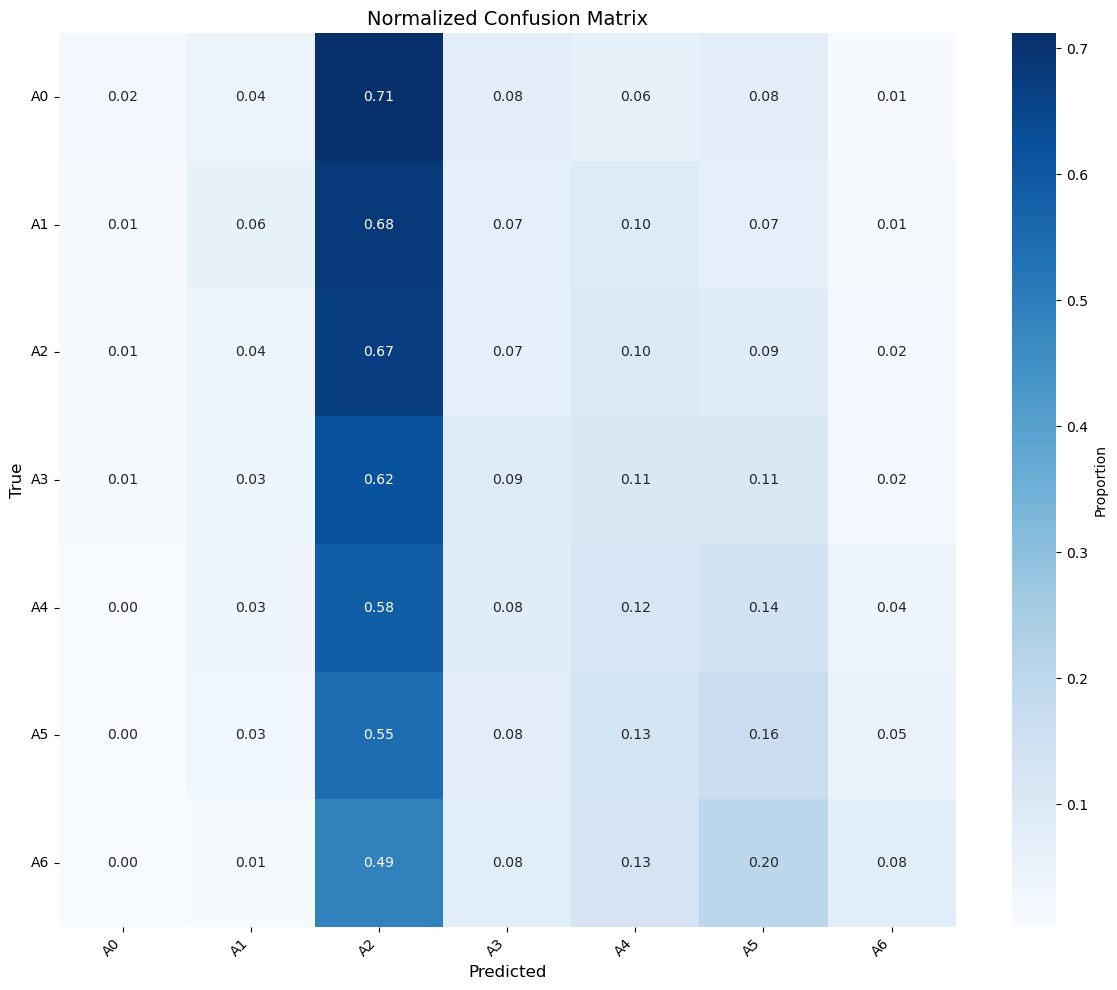


Epoch 6/20


Train Loss: 1.2304, Train Accuracy: 0.2298, Train Adjacent Accuracy: 0.5612

Epoch 7/20


Train Loss: 1.2254, Train Accuracy: 0.2326, Train Adjacent Accuracy: 0.5590

Epoch 8/20


Train Loss: 1.2194, Train Accuracy: 0.2405, Train Adjacent Accuracy: 0.5730

Epoch 9/20


Train Loss: 1.2121, Train Accuracy: 0.2413, Train Adjacent Accuracy: 0.5707

Epoch 10/20


Train Loss: 1.2056, Train Accuracy: 0.2469, Train Adjacent Accuracy: 0.5758



Overall Metrics:
Loss:                1.2541
Accuracy (Exact):    0.2012
Accuracy (±1 bin):   0.5431

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0556       0.0382       0.0453       288       
A1              0.2129       0.2941       0.2470       901       
A2              0.2177       0.3333       0.2634       1092      
A3              0.2118       0.1739       0.1910       1035      
A4              0.1966       0.0874       0.1210       915       
A5              0.1753       0.1436       0.1578       592       
A6              0.1767       0.1595       0.1677       351       
----------------------------------------------------------------------
Macro Avg       0.1780       0.1757       0.1704       5174      
Weighted Avg    0.1953       0.2012       0.1902       5174      


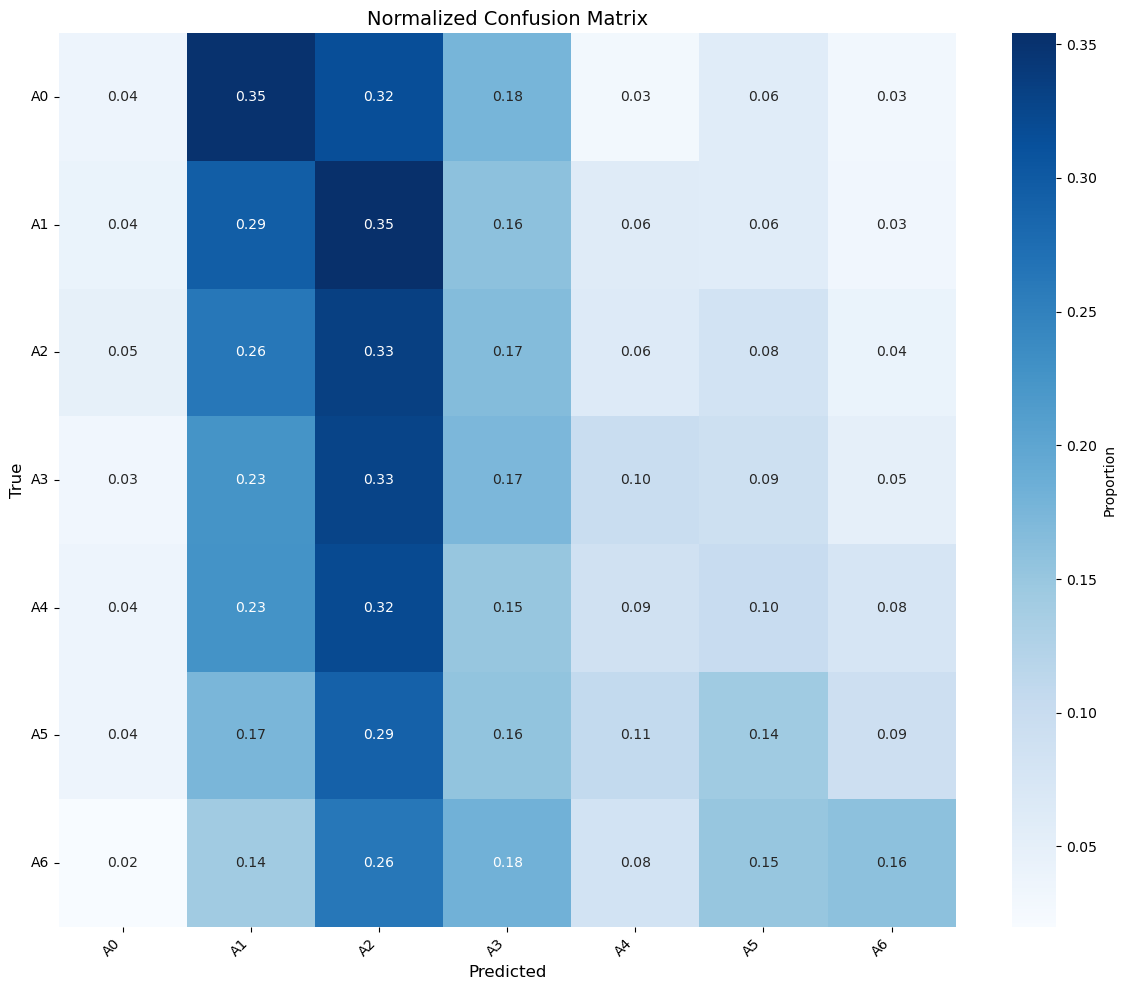


Epoch 11/20


Train Loss: 1.1965, Train Accuracy: 0.2542, Train Adjacent Accuracy: 0.5801

Epoch 12/20


Train Loss: 1.1859, Train Accuracy: 0.2613, Train Adjacent Accuracy: 0.5795

Epoch 13/20


Train Loss: 1.1774, Train Accuracy: 0.2675, Train Adjacent Accuracy: 0.5917

Epoch 14/20


Train Loss: 1.1657, Train Accuracy: 0.2698, Train Adjacent Accuracy: 0.5879

Epoch 15/20


Train Loss: 1.1511, Train Accuracy: 0.2728, Train Adjacent Accuracy: 0.5952



Overall Metrics:
Loss:                1.2757
Accuracy (Exact):    0.1815
Accuracy (±1 bin):   0.5087

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0769       0.0521       0.0621       288       
A1              0.2035       0.1421       0.1673       901       
A2              0.2202       0.2830       0.2477       1092      
A3              0.1722       0.1295       0.1478       1035      
A4              0.1817       0.1869       0.1843       915       
A5              0.1505       0.1622       0.1561       592       
A6              0.1458       0.2450       0.1828       351       
----------------------------------------------------------------------
Macro Avg       0.1644       0.1715       0.1640       5174      
Weighted Avg    0.1799       0.1815       0.1773       5174      


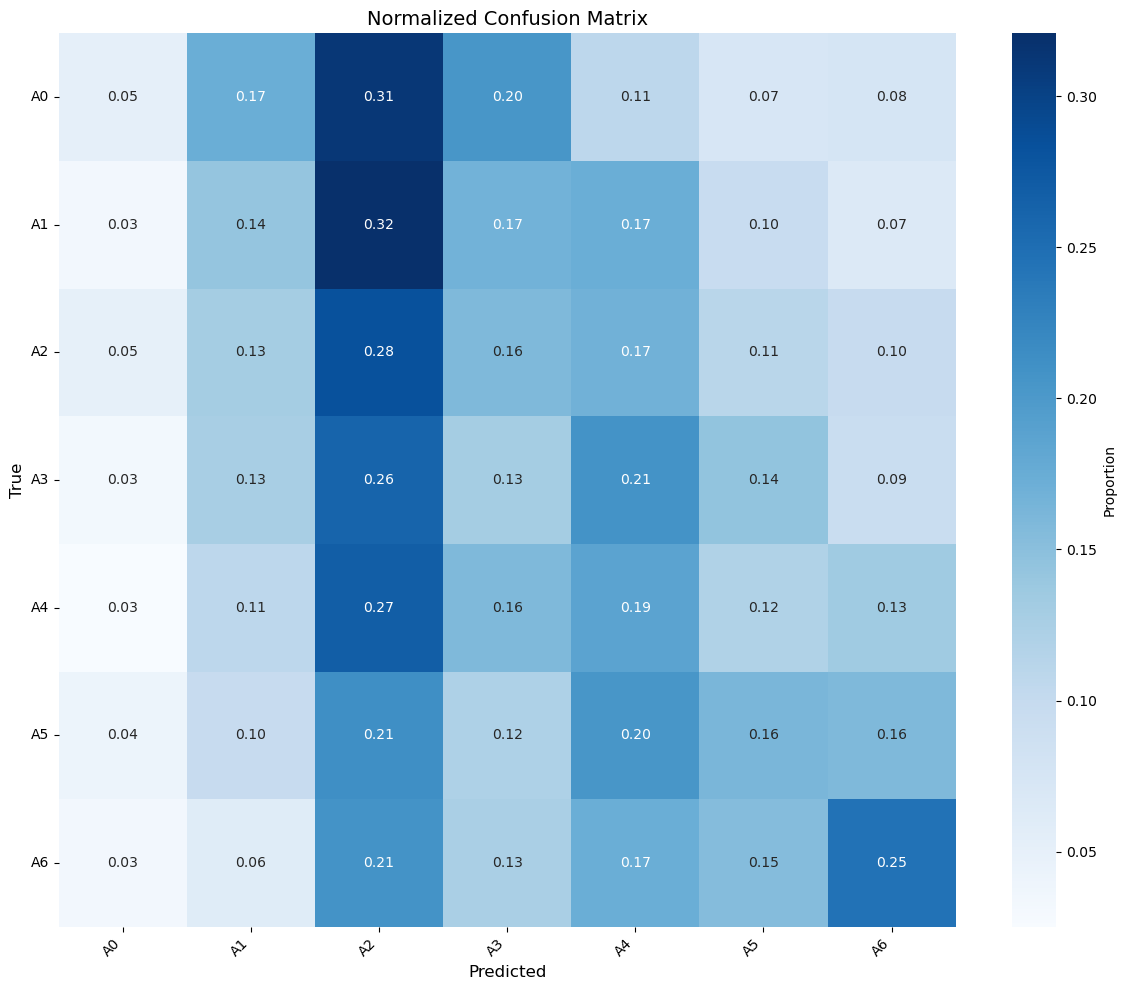


Epoch 16/20


Train Loss: 1.1387, Train Accuracy: 0.2797, Train Adjacent Accuracy: 0.6015

Epoch 17/20


Train Loss: 1.1260, Train Accuracy: 0.2825, Train Adjacent Accuracy: 0.6075

Epoch 18/20


Train Loss: 1.1088, Train Accuracy: 0.2918, Train Adjacent Accuracy: 0.6163

Epoch 19/20


Train Loss: 1.0921, Train Accuracy: 0.3018, Train Adjacent Accuracy: 0.6287

Epoch 20/20


Train Loss: 1.0797, Train Accuracy: 0.3018, Train Adjacent Accuracy: 0.6340



Overall Metrics:
Loss:                1.3080
Accuracy (Exact):    0.1813
Accuracy (±1 bin):   0.4760

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0625       0.1146       0.0809       288       
A1              0.2103       0.3640       0.2666       901       
A2              0.2229       0.1694       0.1925       1092      
A3              0.2024       0.1159       0.1474       1035      
A4              0.2095       0.0820       0.1178       915       
A5              0.1559       0.2078       0.1781       592       
A6              0.1434       0.2108       0.1707       351       
----------------------------------------------------------------------
Macro Avg       0.1724       0.1806       0.1649       5174      
Weighted Avg    0.1922       0.1813       0.1738       5174      


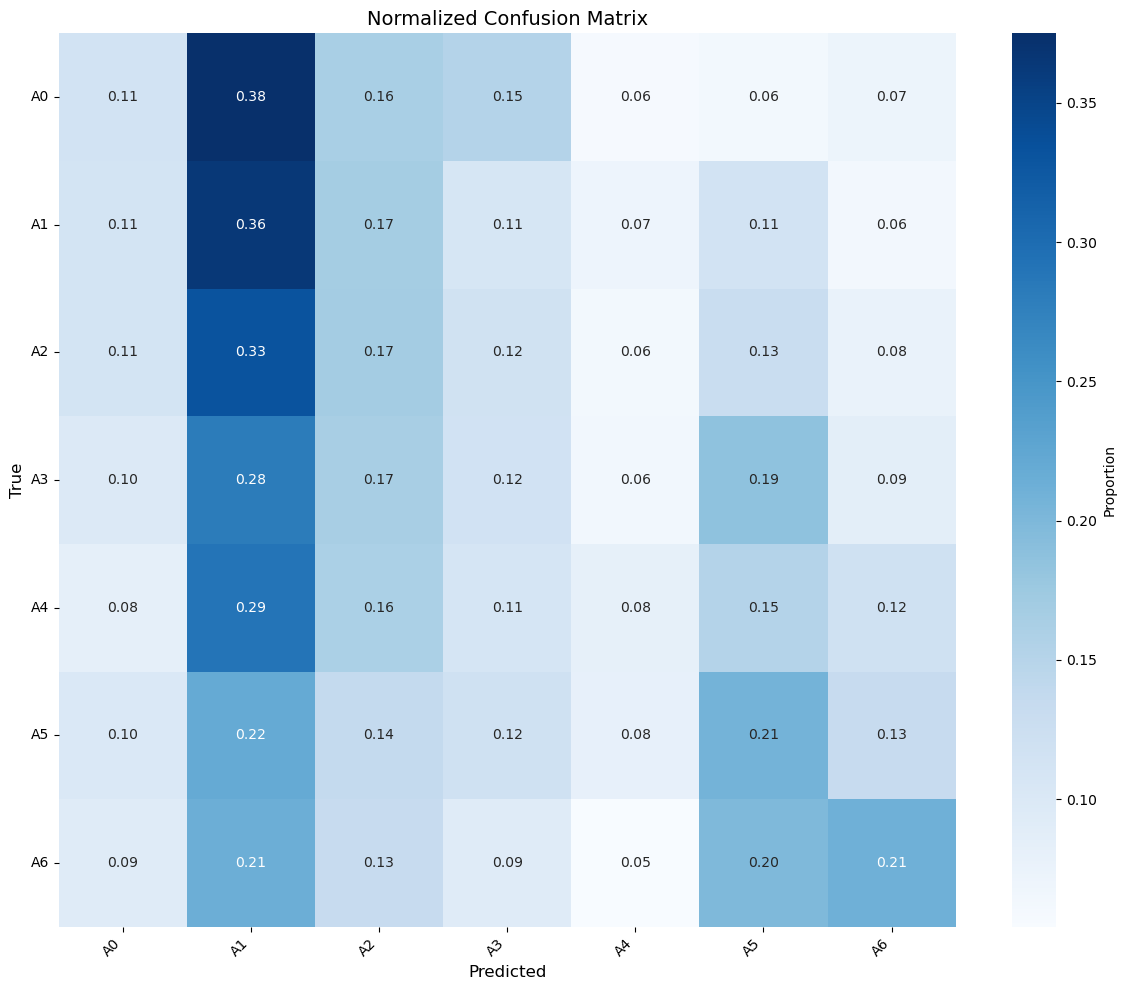

<All keys matched successfully>

In [318]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    scene_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        scene_aro_model, 
        scene_aro_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            scene_aro_model, 
            scene_aro_test_loader, 
            arousal_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
        )
        print_detailed_metrics(results, arousal_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

torch.save(scene_aro_model.state_dict(), os.path.join(model_dir, "scene_aro_model.pth"))
# Load the trained baseline model weights

scene_aro_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)
scene_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_aro_model.pth")))

In [319]:
scene_aro_network = Network(scene_aro_model, "scene_aro_model", batching=True)
scene_aro_network.optimizer = optimizer

In [320]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face backbone features (768 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(768, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (768,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))        

In [321]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (512,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))

In [322]:
emotion_va_bins

{'trust': (4, 3),
 'anticipation': (4, 2),
 'fear': (2, 3),
 'anger': (1, 4),
 'joy': (5, 3),
 'sadness': (1, 3),
 'disgust': (2, 2),
 'surprise': (3, 3)}

In [323]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

In [328]:
emotion_centroids = {}
# For every emotion, count +3 for the valence value
for emo, (valence, arousal) in emotion_va.items():
    valence_centered = valence + 3
    emotion_centroids[emo] = (valence_centered, arousal)

In [329]:
emotion_centroids

{'anger': (1.4243542435424354, 3.5912259122591226),
 'anticipation': (3.562447042874089, 2.463650228774784),
 'disgust': (2.124, 2.441),
 'fear': (1.6609745939192004, 3.239067055393586),
 'joy': (4.902050113895216, 2.9552961275626424),
 'sadness': (1.4292682926829268, 3.4221388367729833),
 'surprise': (3.4763513513513513, 2.5664414414414414),
 'trust': (4.414201183431953, 2.5694561848408)}

In [331]:
[list(emotion_centroids.values())]

[[(1.4243542435424354, 3.5912259122591226),
  (3.562447042874089, 2.463650228774784),
  (2.124, 2.441),
  (1.6609745939192004, 3.239067055393586),
  (4.902050113895216, 2.9552961275626424),
  (1.4292682926829268, 3.4221388367729833),
  (3.4763513513513513, 2.5664414414414414),
  (4.414201183431953, 2.5694561848408)]]

In [332]:
class VA2Emotion(nn.Module):
    def __init__(self, centroids):
        super().__init__()
        self.centroids = nn.Parameter(torch.tensor(centroids, dtype=torch.float32), requires_grad=False)
        self.log_alpha = nn.Parameter(torch.tensor(0.0))  # learnable temperature

    def forward(self, x):
        # x = tensor of shape (batch, 2) containing valence, arousal
        V = x[:, 0].unsqueeze(1)
        A = x[:, 1].unsqueeze(1)

        C = self.centroids  # shape (8,2)
        # compute squared distances -> shape (batch, 8)
        d2 = (V - C[:,0])**2 + (A - C[:,1])**2
        
        # softmax over negative distances
        alpha = torch.exp(self.log_alpha)
        probs = F.softmax(-alpha * d2, dim=1)
        return probs
    
va2emotion_model_raw = VA2Emotion([list(emotion_centroids.values())])
va2emotion_model = DeviceAwareModule(va2emotion_model_raw).to(DEVICE)

va2emotion_network = Network(va2emotion_model, "va2emotion_model", batching=True)
va2emotion_network.optimizer = torch.optim.AdamW(
    va2emotion_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [334]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_6.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network, va2emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

# model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

In [335]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [336]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),joy), {})

In [337]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [343]:
test_input = torch.load(os.path.join(data_dir, "pretrained_backbone", "faces", "face_0_0.pt")).to(DEVICE)
test_output = face_val_model(test_input.unsqueeze(0))
print(test_output)
test_output.shape

tensor([[[5.3549e-04, 1.3191e-03, 2.4600e-03, 9.7618e-03, 9.2532e-02,
          3.3119e-01, 5.6220e-01]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


torch.Size([1, 1, 7])

In [341]:
test_idx = np.random.choice(test_indices)

# debug_query(model,
#             "closest_emotion",
#             Term("tensor", Constant(2), Constant(4)),
#             Var("E"))

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Term(df.iloc[test_idx]['emotion']))

print("Debugging queries done.")

Exception ignored on calling ctypes callback function: <function _foreignWrapper.<locals>.wrapper at 0x0000022366FFC430>
Traceback (most recent call last):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\pyswip\easy.py", line 528, in wrapper
    r = fun(*args)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\engines\approximate_engine.py", line 156, in func
    output_var.unify([float(x) for x in probabilities])
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\engines\approximate_engine.py", line 156, in <listcomp>
    output_var.unify([float(x) for x in probabilities])
ValueError: only one element tensors can be converted to Python scalars



Testing: test_face_val_bin


PrologError: Caused by: 'prove(test_face_val_bin(tensor(face_features_test(15190)),VBin),10,Proofs,geometric_mean,false)'. Returned: 'error(domain_error(foreign_return_value, 12), context(/(face_val_model_extern, 2), _10296))'.

In [ ]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [243]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:6.9489 	Average Loss:  4.334870085120201
Iteration:  4 	s:16.3592 	Average Loss:  7.851691976189613
Iteration:  6 	s:12.8264 	Average Loss:  6.288310378789902
Iteration:  8 	s:12.0902 	Average Loss:  5.522166226059198
Iteration:  10 	s:11.6634 	Average Loss:  4.810750685632229
Iteration:  12 	s:12.5543 	Average Loss:  4.515112046152353
Iteration:  14 	s:12.3480 	Average Loss:  4.250451292842627
Iteration:  16 	s:12.2610 	Average Loss:  3.970181681215763
Iteration:  18 	s:11.9936 	Average Loss:  3.6256477162241936
Iteration:  20 	s:12.0579 	Average Loss:  3.4114834647625685
Iteration:  22 	s:12.3569 	Average Loss:  3.523930437862873
Iteration:  24 	s:11.9837 	Average Loss:  3.178126698359847
Iteration:  26 	s:12.3767 	Average Loss:  3.1057228334248066
Iteration:  28 	s:11.7233 	Average Loss:  2.9210910983383656
Iteration:  30 	s:12.4318 	Average Loss:  2.8178756134584546
Iteration:  32 	s:12.1512 	Average Loss:  2.8348735980689526
Iterat

KeyboardInterrupt: 

In [244]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.3693467336683417

Overall Metrics:
Accuracy: 0.3693

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.2500       0.0235       0.0429       511       
anticipation    0.2785       0.7828       0.4108       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.5419       0.6857       0.6054       1416      
sadness         0.3333       0.0039       0.0077       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.1755       0.1870       0.1334       5174      
Weighted Avg    0.2696       0.3693       0.2646       5174      


In [245]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

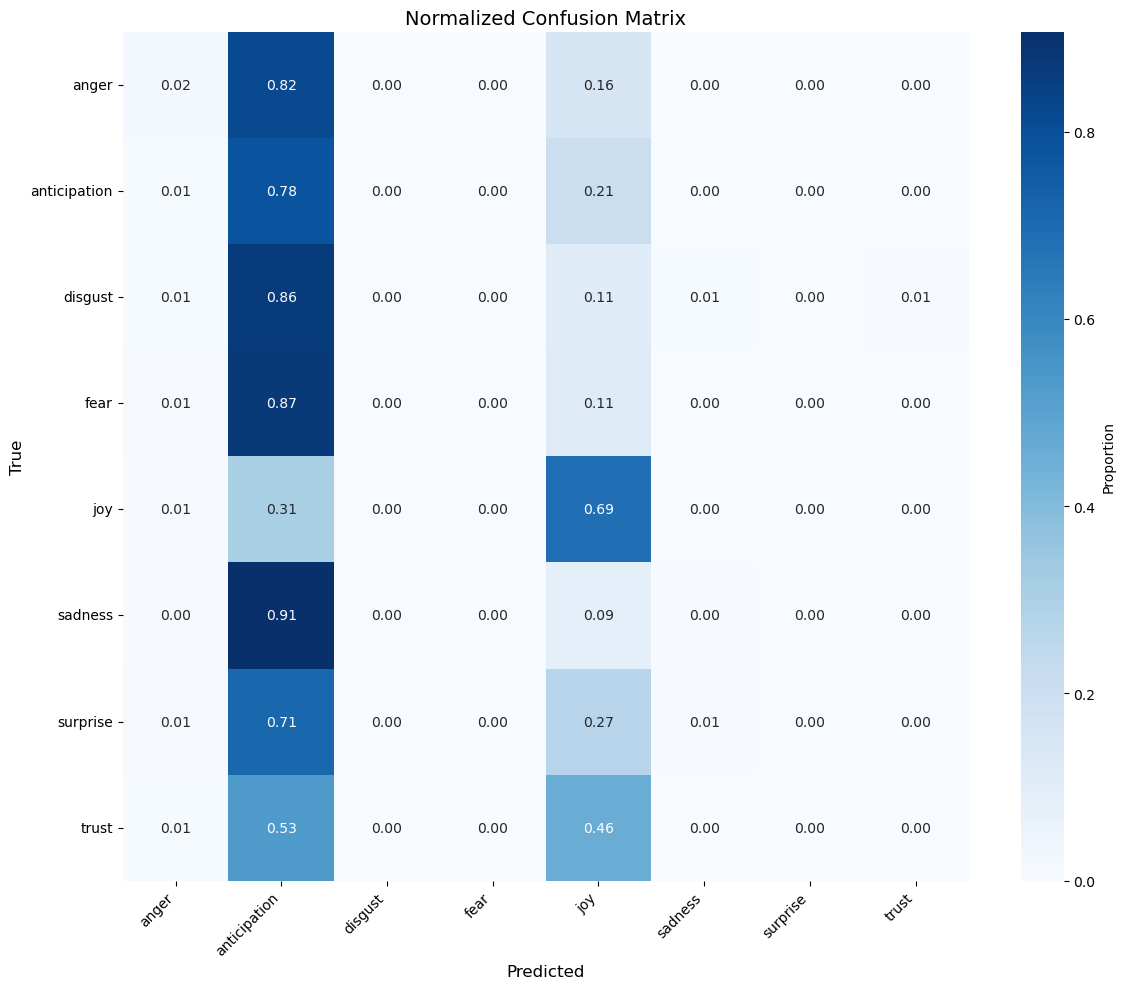

In [246]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)